In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#CSV import for crashes table
filepath = "Datasets/crash_records_ml.csv"
df = pd.read_csv(filepath)
df.head()

,Make,Model,Model Year,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Roadway Description,Posted Speed Limit (MPH),Lighting,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,Jaguar,I-Pace,2021,January 2024,12:04,Los Angeles,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,1,0
1,Jaguar,I-Pace,2024,July 2024,04:58,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Dark - Lighted,1,0,0,0,0,0,0,0
2,Jaguar,I-Pace,2024,July 2024,11:29,Phoenix,AZ,Parking Lot,Dry,No Unusual Conditions,5.0,Daylight,1,0,0,0,0,0,0,1
3,Jaguar,I-Pace,2024,July 2024,18:16,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,0,0
4,Jaguar,I-Pace,2024,July 2024,11:06,Austin,TX,Street,Dry,No Unusual Conditions,40.0,Daylight,0,0,1,0,0,0,0,1


In [3]:
df = df.dropna()

In [4]:
df.columns

Index(['Make', 'Model', 'Model Year', 'Incident Date', 'Incident Time (24:00)',
       'City', 'State', 'Roadway Type', 'Roadway Surface',
       'Roadway Description', 'Posted Speed Limit (MPH)', 'Lighting', 'Clear',
       'Snow', 'Cloudy', 'Fog/Smoke', 'Rain', 'Severe Wind', 'Injuries',
       'Passengers Belted'],
      dtype='object')

In [5]:
cols_to_drop= ['City', 'State','Make','Model', 'Incident Date','Roadway Description','Incident Date','Lighting']
df_ml = df.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,0,0,1


In [6]:
#  Dropping the columns with no positive results for the period that was covered by this report.
#  May need to re-instate as more incidents come up
cols_to_drop= ['Severe Wind', 'Fog/Smoke']
df_ml = df_ml.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,1


In [7]:
# df_ml.loc[df_ml['Weather - Clear'] == 'Y', 'Weather - Clear'] = 'Clear'
# df_ml.loc[df_ml['Weather - Snow'] == 'Y', 'Weather - Snow'] = 'Snow'
# df_ml.loc[df_ml['Weather - Cloudy'] == 'Y', 'Weather - Cloudy'] = 'Cloudy'
# df_ml.loc[df_ml['Weather - Rain'] == 'Y', 'Weather - Rain'] = 'Rain'
# df_ml['Weather'] = df_ml[['Weather - Clear', 'Weather - Snow', 'Weather - Cloudy', 'Weather - Rain']].agg(' '.join, axis=1)
# df_ml.loc[df_ml['Weather'] == '           ', 'Weather'] = 'Clear'
# df_ml['Weather'] = df_ml['Weather'].str.strip()
# df_ml.loc[df_ml['Weather'] == 'Clear   Cloudy', 'Weather'] = 'Clear'
# df_ml.loc[df_ml['Weather'] == 'Cloudy   Rain', 'Weather'] = 'Rain'
# df_ml.loc[df_ml['Weather'] == '            ', 'Weather'] = 'Clear'
# df_ml['Weather'].fillna("Clear", inplace=True)
# df_ml['Weather'] = df_ml['Weather'].str.strip()
# df_ml.head()

In [8]:
def categorize_time(incident_time): #X-pert advised
    if isinstance(incident_time, str):
        if "00:00" <= incident_time < "10:00":
            return "Morning"
        elif "10:00" <= incident_time <= "16:00":
            return "Afternoon"
        else:
            return "Night"
    else:
        return None  # or return a default value, e.g., "Unknown"

# Apply the function to the Incident Time column
df_ml['Incident Time (24:00)'] = df_ml['Incident Time (24:00)'].apply(categorize_time)

In [9]:
df_ml['Incident Time (24:00)'].value_counts()

Incident Time (24:00)
Night        472
Afternoon    451
Morning      405
Name: count, dtype: int64

In [10]:
df_ml = df_ml.rename(columns = {'Incident Time (24:00)': "Time_of_Day"})
df_ml['Time_of_Day'].value_counts()

Time_of_Day
Night        472
Afternoon    451
Morning      405
Name: count, dtype: int64

In [11]:
df_ml = df_ml.rename(columns = {'Posted Speed Limit (MPH)': "Speed_Limit"})
df_ml['Speed_Limit'] = df_ml['Speed_Limit'].astype(int)


In [12]:
# bins = [-float('inf'), 20, 40, 60, 80, float('inf')]
# labels = ['<=20', '20-40', '40-60', '60-80', '>80']
# df_ml['Speed_Category'] = pd.cut(df_ml['Speed_Limit'], bins=bins, labels=labels)
# df_ml.head()

In [13]:
df_ml = df_ml.rename(columns = {"Model Year": "Model_Year", "Roadway Type": "Roadway_Type", "Roadway Surface": "Roadway_Surface", "Passengers Belted": "Passengers_Belted"})
df_ml.columns

Index(['Model_Year', 'Time_of_Day', 'Roadway_Type', 'Roadway_Surface',
       'Speed_Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Injuries',
       'Passengers_Belted'],
      dtype='object')

In [14]:
df_ml

,Model_Year,Time_of_Day,Roadway_Type,Roadway_Surface,Speed_Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers_Belted
0,2021,Afternoon,Street,Dry,25,1,0,0,0,1,0
1,2024,Morning,Street,Dry,25,1,0,0,0,0,0
2,2024,Afternoon,Parking Lot,Dry,5,1,0,0,0,0,1
3,2024,Night,Street,Dry,25,1,0,0,0,0,0
4,2024,Afternoon,Street,Dry,40,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1357,2017,Afternoon,Intersection,Dry,25,0,0,1,0,0,1
1358,2021,Night,Street,Dry,25,1,0,0,0,0,1
1359,2021,Night,Street,Dry,25,1,0,0,0,0,1
1360,2017,Afternoon,Intersection,Dry,25,0,0,1,0,0,1


In [15]:
df_ml.columns

Index(['Model_Year', 'Time_of_Day', 'Roadway_Type', 'Roadway_Surface',
       'Speed_Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Injuries',
       'Passengers_Belted'],
      dtype='object')

In [16]:
df_ml['Roadway_Type'] = df_ml['Roadway_Type'].replace({
    'Unknown': 'Other',
    'Traffic Circle': 'Other',
    'Parking Lot': 'Other',
    'Highway / Freeway': 'Highway'
})

In [17]:
df_ml['Roadway_Type'].value_counts()

Roadway_Type
Intersection    590
Street          571
Highway          99
Other            68
Name: count, dtype: int64

In [18]:
df_ml['Roadway_Surface'] = df_ml['Roadway_Surface'].replace({
    'Unknown': 'Wet',
    'Snow / Slush / Ice': 'Wet'
})

In [19]:
df_ml = pd.get_dummies(df_ml, dtype=int)
df_ml.head()

,Model_Year,Speed_Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers_Belted,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Night,Roadway_Type_Highway,Roadway_Type_Intersection,Roadway_Type_Other,Roadway_Type_Street,Roadway_Surface_Dry,Roadway_Surface_Wet
0,2021,25,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0
1,2024,25,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,2024,5,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0
3,2024,25,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0
4,2024,40,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0


In [20]:
# df_ml['Roadway_Surface'].value_counts()

In [21]:
df_ml['Model_Year'].value_counts()

Model_Year
2021    558
2023    268
2020    134
2022    118
2024     96
2017     48
2016     46
2019     44
9999      8
2018      8
Name: count, dtype: int64

In [22]:
df_ml['Speed_Limit'].value_counts()

Speed_Limit
25    751
30    147
35    110
45     58
15     54
65     53
20     45
40     40
75     30
5      13
10      5
55      5
0       4
70      4
60      4
9       3
50      1
1       1
Name: count, dtype: int64

In [23]:
# df_ml['Speed Category'].value_counts()

In [24]:
df_ml.head()

,Model_Year,Speed_Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers_Belted,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Night,Roadway_Type_Highway,Roadway_Type_Intersection,Roadway_Type_Other,Roadway_Type_Street,Roadway_Surface_Dry,Roadway_Surface_Wet
0,2021,25,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0
1,2024,25,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,2024,5,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0
3,2024,25,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0
4,2024,40,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0


In [25]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1361
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Model_Year                 1328 non-null   int64
 1   Speed_Limit                1328 non-null   int32
 2   Clear                      1328 non-null   int64
 3   Snow                       1328 non-null   int64
 4   Cloudy                     1328 non-null   int64
 5   Rain                       1328 non-null   int64
 6   Injuries                   1328 non-null   int64
 7   Passengers_Belted          1328 non-null   int64
 8   Time_of_Day_Afternoon      1328 non-null   int32
 9   Time_of_Day_Morning        1328 non-null   int32
 10  Time_of_Day_Night          1328 non-null   int32
 11  Roadway_Type_Highway       1328 non-null   int32
 12  Roadway_Type_Intersection  1328 non-null   int32
 13  Roadway_Type_Other         1328 non-null   int32
 14  Roadway_Type_Street        13

In [26]:
df_ml.describe()

,Model_Year,Speed_Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers_Belted,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Night,Roadway_Type_Highway,Roadway_Type_Intersection,Roadway_Type_Other,Roadway_Type_Street,Roadway_Surface_Dry,Roadway_Surface_Wet
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,2069.266566,29.847892,0.827560,0.000753,0.128012,0.033133,0.197289,0.648343,0.339608,0.304970,0.355422,0.074548,0.444277,0.051205,0.429970,0.949548,0.050452
std,617.564092,12.588295,0.377905,0.027441,0.334229,0.179050,0.398102,0.477667,0.473755,0.460568,0.478821,0.262760,0.497072,0.220498,0.495258,0.218958,0.218958
min,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2023.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,9999.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1361
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Model_Year                 1328 non-null   int64
 1   Speed_Limit                1328 non-null   int32
 2   Clear                      1328 non-null   int64
 3   Snow                       1328 non-null   int64
 4   Cloudy                     1328 non-null   int64
 5   Rain                       1328 non-null   int64
 6   Injuries                   1328 non-null   int64
 7   Passengers_Belted          1328 non-null   int64
 8   Time_of_Day_Afternoon      1328 non-null   int32
 9   Time_of_Day_Morning        1328 non-null   int32
 10  Time_of_Day_Night          1328 non-null   int32
 11  Roadway_Type_Highway       1328 non-null   int32
 12  Roadway_Type_Intersection  1328 non-null   int32
 13  Roadway_Type_Other         1328 non-null   int32
 14  Roadway_Type_Street        13

In [28]:
# features = ['Model_Year', 'Time_of_Day', 'Roadway_Type', 'Roadway_Surface', 'Speed_Limit'
#         'Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers_Belted']
# #'Speed Limit',

# # We are looking to see if Injuries are resultant from various characteristics, as a result "Injuries" was dropped from the features as it'll be against our test case.

In [29]:
# df_ml.columns

In [30]:
# ## Need  to do a classificiation model

# # Define Preprocessing Pipelines

# # Define preprocessing for numeric features (Age, Fare, Family_Size) (note that for age, we just use the column median, not split by gender)
# #, 'Speed Limit'
# numeric_features = ['Model_Year', 'Speed_Limit'] # You can also do this in a loop, select the numeric columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median'))])
#     # ('scaler', StandardScaler())])

# # # Define preprocessing for the binary features ('CryoSleep', 'VIP', 'Side')
# binary_features = ['Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers_Belted']
# binary_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
#     ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])  # Label encode for binary feature

# # # Define preprocessing for categorical features ('HomePlanet', 'Destination', 'Deck') 
# #, 'Speed Category'
# categorical_features = ['Time_of_Day_Morning', 'Time_of_Day_Afternoon','Roadway_Type', 'Roadway_Surface']
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# # # Combine preprocessing for numeric and categorical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('binary', binary_transformer, binary_features),
#         ('cat', categorical_transformer, categorical_features)])

In [31]:
# # Use only preprocessing pipeline to transform the data
# preprocessed_X_train = preprocessor.fit_transform(df_ml)

# # Convert preprocessed data to a DataFrame
# # Get the feature names after one-hot encoding
# encoded_feature_names = (numeric_features + binary_features +
#                          list(preprocessor.transformers_[2][1]['onehot'].get_feature_names_out(categorical_features)))

# df_final = pd.DataFrame(preprocessed_X_train, columns=encoded_feature_names)
# df_final["Injuries"] = df_ml.Injuries
# df_final.head()

In [32]:
# Create a stratified train/test split. 
# Test set will be 30% of the data.
# Class distribution will be equal for train test and original data
# features
X = df_ml.drop(["Injuries",], axis=1) # keep ALL features except for the target

# target
y = df_ml.Injuries

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

print(X_train.shape)
print(X_test.shape)

(996, 16)
(332, 16)


In [33]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [34]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (1598, 16)
After OverSampling, the shape of train_y: (1598,) 

After OverSampling, counts of label '1': 799
After OverSampling, counts of label '0': 799


In [35]:
corrs = df_ml.corr()
corrs

,Model_Year,Speed_Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers_Belted,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Night,Roadway_Type_Highway,Roadway_Type_Intersection,Roadway_Type_Other,Roadway_Type_Street,Roadway_Surface_Dry,Roadway_Surface_Wet
Model_Year,1.000000,-0.068551,0.009522,-0.002102,-0.000476,-0.014296,0.010235,-0.004817,0.046315,-0.008913,-0.037253,-0.021814,-0.030424,0.114305,-0.008782,0.017844,-0.017844
Speed_Limit,-0.068551,1.000000,-0.134621,0.011239,0.163143,0.013940,0.042082,0.268441,0.101795,-0.049833,-0.052785,0.828161,-0.162614,-0.241535,-0.168636,-0.006887,0.006887
Clear,0.009522,-0.134621,1.000000,-0.060138,-0.833400,-0.405532,0.086051,-0.077354,-0.059895,0.003629,0.055771,-0.189184,0.079189,0.024652,0.009917,0.459428,-0.459428
Snow,-0.002102,0.011239,-0.060138,1.000000,-0.010518,-0.005082,-0.013609,0.020217,0.038280,-0.018184,-0.020384,-0.007791,-0.024545,-0.006377,0.031608,-0.119093,0.119093
Cloudy,-0.000476,0.163143,-0.833400,-0.010518,1.000000,-0.020558,-0.037035,0.083933,0.115489,-0.053090,-0.063200,0.217323,-0.047750,-0.037883,-0.050510,-0.107331,0.107331
Rain,-0.014296,0.013940,-0.405532,-0.005082,-0.020558,1.000000,-0.091773,-0.031078,-0.035027,0.051003,-0.014403,0.011531,-0.055444,-0.043004,0.068676,-0.803090,0.803090
Injuries,0.010235,0.042082,0.086051,-0.013609,-0.037035,-0.091773,1.000000,0.115454,-0.011897,0.057942,-0.043963,-0.003830,0.040364,-0.037907,-0.021603,0.096985,-0.096985
Passengers_Belted,-0.004817,0.268441,-0.077354,0.020217,0.083933,-0.031078,0.115454,1.000000,0.201791,-0.186954,-0.019828,0.209025,0.071340,-0.057863,-0.156738,0.003163,-0.003163
Time_of_Day_Afternoon,0.046315,0.101795,-0.059895,0.038280,0.115489,-0.035027,-0.011897,0.201791,1.000000,-0.475024,-0.532504,0.111258,-0.071582,0.064252,-0.015790,0.041799,-0.041799
Time_of_Day_Morning,-0.008913,-0.049833,0.003629,-0.018184,-0.053090,0.051003,0.057942,-0.186954,-0.475024,1.000000,-0.491882,-0.057238,0.056181,-0.005476,-0.023581,-0.026655,0.026655


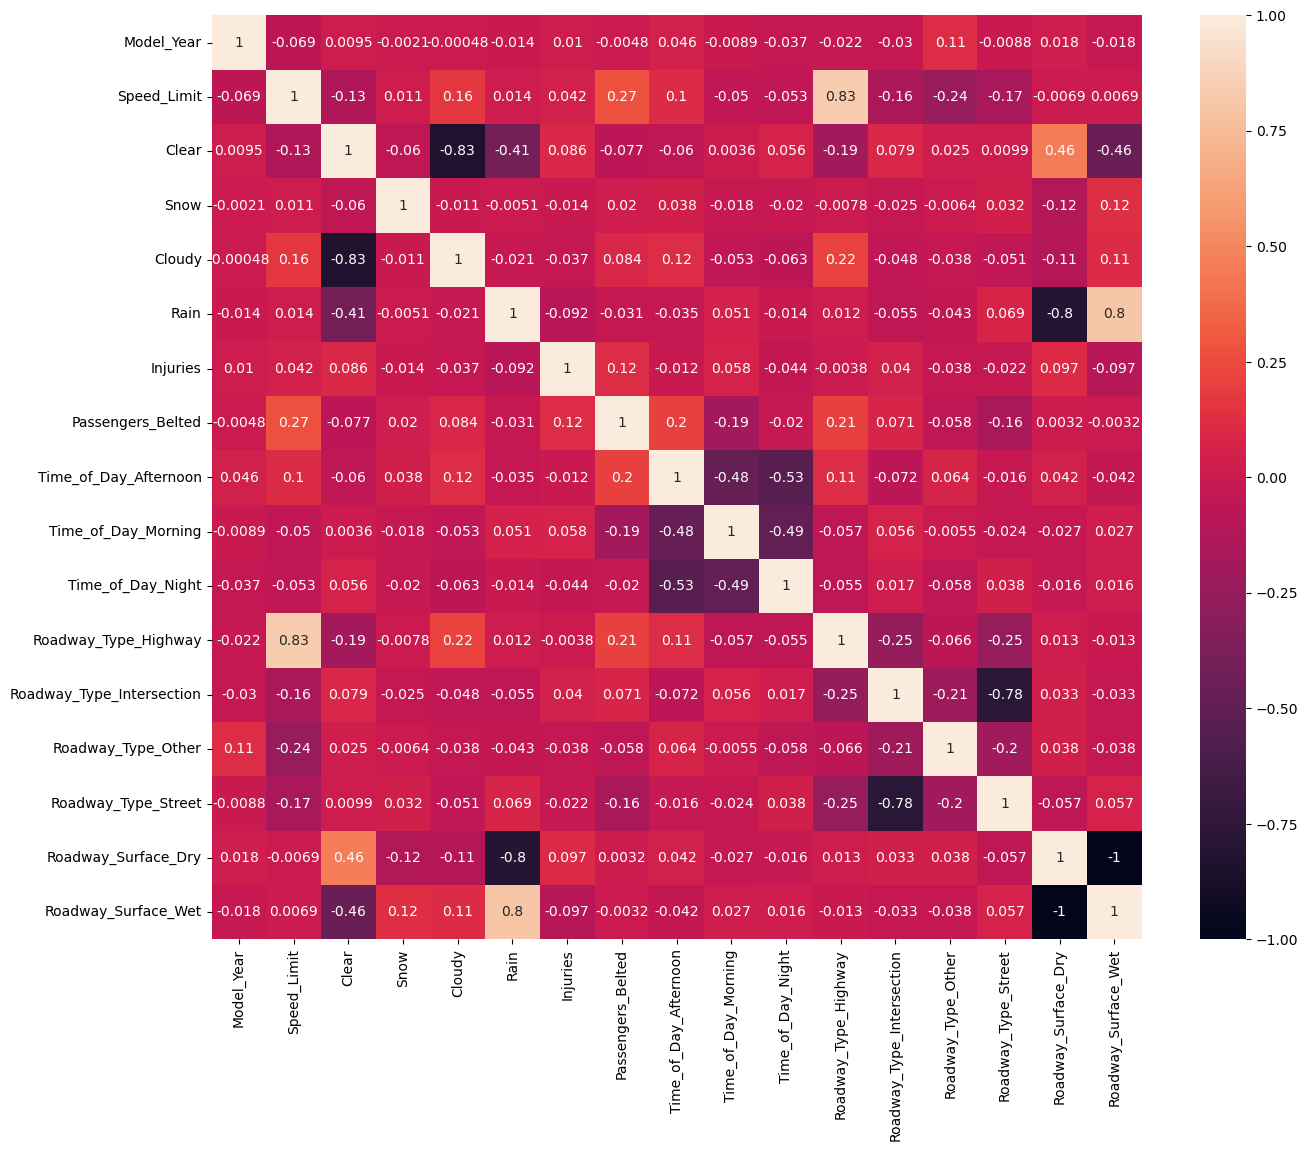

In [36]:
plt.figure(figsize=(15,12))
sns.heatmap(corrs, annot=True)
plt.show()

In [37]:
abs(corrs.Injuries).sort_values(ascending=False)

Injuries                     1.000000
Passengers_Belted            0.115454
Roadway_Surface_Dry          0.096985
Roadway_Surface_Wet          0.096985
Rain                         0.091773
Clear                        0.086051
Time_of_Day_Morning          0.057942
Time_of_Day_Night            0.043963
Speed_Limit                  0.042082
Roadway_Type_Intersection    0.040364
Roadway_Type_Other           0.037907
Cloudy                       0.037035
Roadway_Type_Street          0.021603
Snow                         0.013609
Time_of_Day_Afternoon        0.011897
Model_Year                   0.010235
Roadway_Type_Highway         0.003830
Name: Injuries, dtype: float64

In [38]:
# X = df_ml.drop(columns=["Injuries"])
# y = df_ml.Injuries

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
# print(X_train.shape, X_test.shape)

In [39]:
X_train.head()

,Model_Year,Speed_Limit,Clear,Snow,Cloudy,Rain,Passengers_Belted,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Night,Roadway_Type_Highway,Roadway_Type_Intersection,Roadway_Type_Other,Roadway_Type_Street,Roadway_Surface_Dry,Roadway_Surface_Wet
528,2023,25,0,0,1,0,0,0,1,0,0,0,0,1,1,0
980,2017,30,0,0,1,0,1,1,0,0,0,1,0,0,1,0
984,2022,25,1,0,0,0,0,0,1,0,0,0,0,1,1,0
1071,2020,25,1,0,0,0,1,0,1,0,0,0,0,1,1,0
16,2021,25,1,0,0,0,1,0,0,1,0,1,0,0,1,0


In [40]:
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix: 
    [[799   0]
 [197   0]]
    
    AUC: 0.6319034580027063

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       799
           1       0.00      0.00      0.00       197

    accuracy                           0.80       996
   macro avg       0.40      0.50      0.45       996
weighted avg       0.64      0.80      0.71       996

    
TEST METRICS
    Confusion Matrix: 
    [[267   0]
 [ 65   0]]
    
    AUC: 0.5672428694900605

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       267
           1       0.00      0.00      0.00        65

    accuracy                           0.80       332
   macro avg       0.40      0.50      0.45       332
weighted avg       0.65      0.80      0.72       332

    


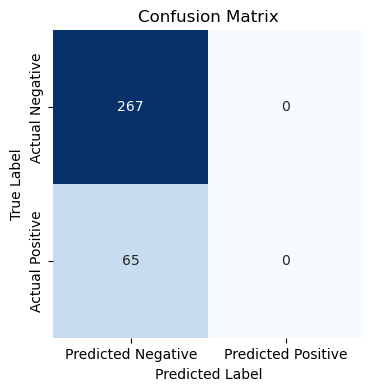

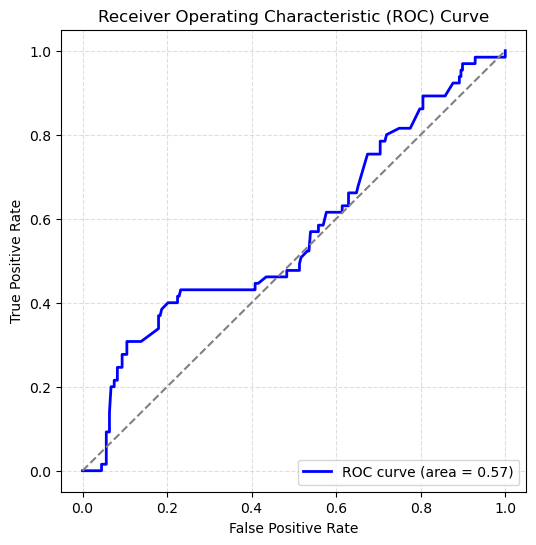

In [41]:
lr = LogisticRegression()

# fit
lr.fit(X_train, y_train)

doClassification(lr, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[772  27]
 [ 74 123]]
    
    AUC: 0.9453345870154952

    Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.97      0.94       799
           1       0.82      0.62      0.71       197

    accuracy                           0.90       996
   macro avg       0.87      0.80      0.82       996
weighted avg       0.89      0.90      0.89       996

    
TEST METRICS
    Confusion Matrix: 
    [[234  33]
 [ 31  34]]
    
    AUC: 0.8366176894266781

    Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.88      0.88       267
           1       0.51      0.52      0.52        65

    accuracy                           0.81       332
   macro avg       0.70      0.70      0.70       332
weighted avg       0.81      0.81      0.81       332

    


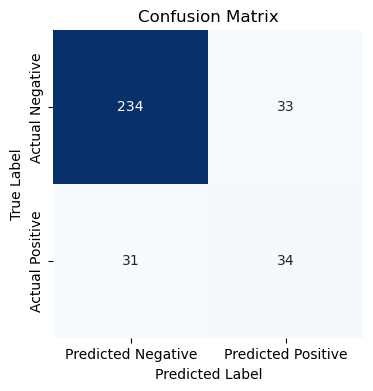

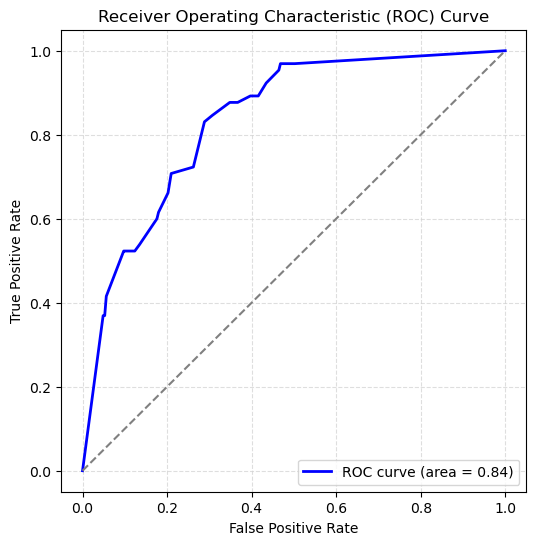

In [42]:
# Step 2: Init the Model
dt = DecisionTreeClassifier()

# fit
dt.fit(X_train, y_train)

doClassification(dt, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[769  30]
 [ 71 126]]
    
    AUC: 0.9394579518814762

    Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.96      0.94       799
           1       0.81      0.64      0.71       197

    accuracy                           0.90       996
   macro avg       0.86      0.80      0.83       996
weighted avg       0.89      0.90      0.89       996

    
TEST METRICS
    Confusion Matrix: 
    [[244  23]
 [ 32  33]]
    
    AUC: 0.8521175453759723

    Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.91      0.90       267
           1       0.59      0.51      0.55        65

    accuracy                           0.83       332
   macro avg       0.74      0.71      0.72       332
weighted avg       0.83      0.83      0.83       332

    


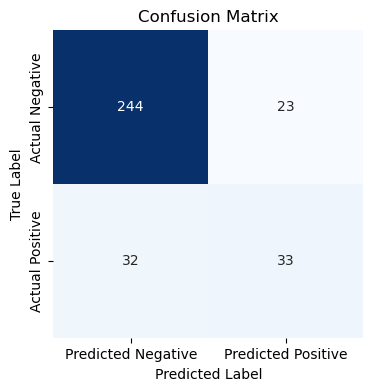

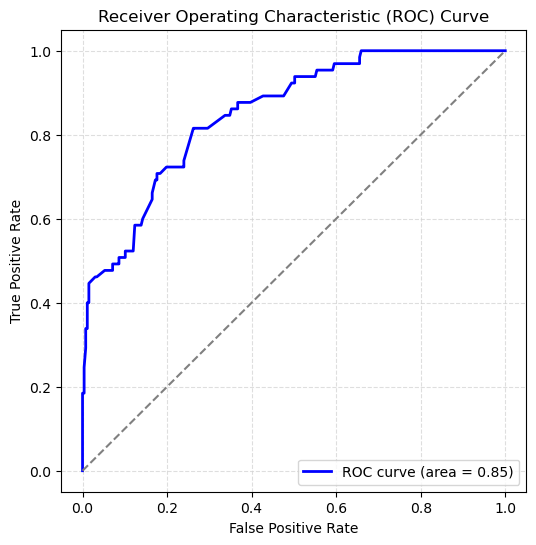

In [43]:
# initialize RandomForest
rf = RandomForestClassifier(random_state=42)

# fit
rf.fit(X_train, y_train)

doClassification(rf, X_train, X_test, y_train, y_test)

In [44]:
X_train.columns

Index(['Model_Year', 'Speed_Limit', 'Clear', 'Snow', 'Cloudy', 'Rain',
       'Passengers_Belted', 'Time_of_Day_Afternoon', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'Roadway_Type_Highway',
       'Roadway_Type_Intersection', 'Roadway_Type_Other',
       'Roadway_Type_Street', 'Roadway_Surface_Dry', 'Roadway_Surface_Wet'],
      dtype='object')

TRAIN METRICS
    Confusion Matrix: 
    [[799   0]
 [197   0]]
    
    AUC: 0.4532601030475912

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       799
           1       0.00      0.00      0.00       197

    accuracy                           0.80       996
   macro avg       0.40      0.50      0.45       996
weighted avg       0.64      0.80      0.71       996

    
TEST METRICS
    Confusion Matrix: 
    [[267   0]
 [ 65   0]]
    
    AUC: 0.446355517142034

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       267
           1       0.00      0.00      0.00        65

    accuracy                           0.80       332
   macro avg       0.40      0.50      0.45       332
weighted avg       0.65      0.80      0.72       332

    


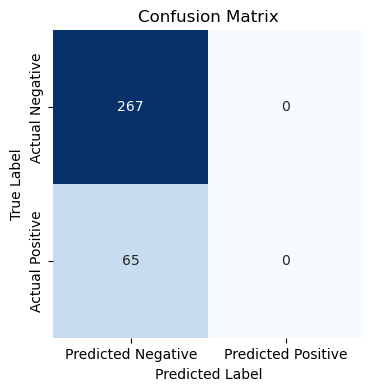

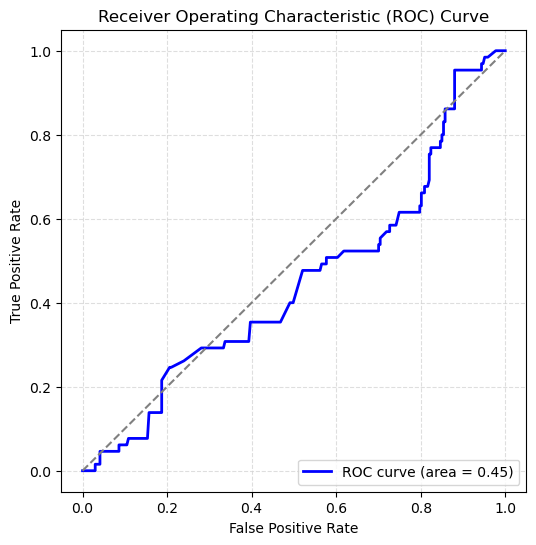

In [45]:
sv = SVC(probability=True)

# fit
sv.fit(X_train, y_train)

doClassification(sv, X_train, X_test, y_train, y_test)

In [46]:
# # initialize KNeighbors
# knn = KNeighborsClassifier(n_neighbors=7)

# # fit
# knn.fit(X_train, y_train)

# doClassification(knn, X_train, X_test, y_train, y_test)

In [47]:
# # Step 2: Init the Model
# et = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', ExtraTreesClassifier(random_state=42))
# ])

# # Do Machine Learning
# doClassification(et, X_train, X_test, y_train, y_test)

In [48]:
# # Step 2: Init the Model
# ada = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', AdaBoostClassifier(random_state=42))
# ])

# # Do Machine Learning
# doClassification(ada, X_train, X_test, y_train, y_test)

In [49]:
# # Step 2: Init the Model
# gb = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier(random_state=42))
# ])

# # Do Machine Learning
# doClassification(gb, X_train, X_test, y_train, y_test)

In [50]:
# # Step 2: Init the Model
# xgb = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', XGBClassifier(random_state=42))
# ])

# # Do Machine Learning
# doClassification(xgb, X_train, X_test, y_train, y_test)

In [51]:
# # Step 2: Init the Model
# lgbm = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LGBMClassifier(random_state=42, verbose=-1))
# ])

# # Do Machine Learning
# doClassification(lgbm, X_train, X_test, y_train, y_test)

In [52]:
# fi = pd.DataFrame(list(zip(X.columns, rf.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
# fi.sort_values(by="Importance", ascending=False)

In [53]:
# fi = pd.DataFrame(list(zip(X.columns, xgb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
# fi.sort_values(by="Importance", ascending=False)

In [54]:
# fi = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['classifier'].feature_importances_ / sum(lgbm.named_steps['classifier'].feature_importances_))), columns=["Feature", "Importance"])
# fi.sort_values(by="Importance", ascending=False)

In [55]:
# fi = pd.DataFrame(list(zip(X.columns, ada.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
# fi.sort_values(by="Importance", ascending=False)

In [56]:
# # Create a pipeline with a scaler and a logistic regression model
# lr = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression())
# ])

# # Perform 5-fold cross-validation with roc_auc scoring
# cv = StratifiedKFold(n_splits=5)
# cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')

# # Output the results
# print(f"Cross-validation AUC scores: {cv_scores}")
# print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [57]:
# # Create a pipeline with a scaler and a logistic regression model
# ada = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', AdaBoostClassifier(random_state=42))
# ])

# # Perform 5-fold cross-validation with roc_auc scoring
# cv = StratifiedKFold(n_splits=5)
# cv_scores = cross_val_score(ada, X, y, cv=cv, scoring='roc_auc')

# # Output the results
# print(f"Cross-validation AUC scores: {cv_scores}")
# print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [58]:
# # Create a pipeline with a scaler and a logistic regression model
# gb = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier(random_state=42))
# ])

# # Perform 5-fold cross-validation with roc_auc scoring
# cv = StratifiedKFold(n_splits=5)
# cv_scores = cross_val_score(gb, X, y, cv=cv, scoring='roc_auc')

# # Output the results
# print(f"Cross-validation AUC scores: {cv_scores}")
# print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [59]:
# # Create a pipeline with a scaler and a logistic regression model
# rf = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Perform 5-fold cross-validation with roc_auc scoring
# cv = StratifiedKFold(n_splits=5)
# cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')

# # Output the results
# print(f"Cross-validation AUC scores: {cv_scores}")
# print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [60]:
# # Create a pipeline with a scaler and a logistic regression model
# lgbm = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LGBMClassifier(random_state=42, verbose=-1))
# ])

# # Perform 5-fold cross-validation with roc_auc scoring
# cv = StratifiedKFold(n_splits=5)
# cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')

# # Output the results
# print(f"Cross-validation AUC scores: {cv_scores}")
# print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [61]:
# initialize
final_model = RandomForestClassifier()

X_res, y_res = sm.fit_resample(X, y.ravel())

# fit
final_model.fit(X_res, y_res)

RandomForestClassifier()

In [62]:
# Save off my models
import pickle

# Model
pickle.dump(rf, open("car_crash_ml_v2.h5", 'wb'))

In [63]:
X.columns

Index(['Model_Year', 'Speed_Limit', 'Clear', 'Snow', 'Cloudy', 'Rain',
       'Passengers_Belted', 'Time_of_Day_Afternoon', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'Roadway_Type_Highway',
       'Roadway_Type_Intersection', 'Roadway_Type_Other',
       'Roadway_Type_Street', 'Roadway_Surface_Dry', 'Roadway_Surface_Wet'],
      dtype='object')